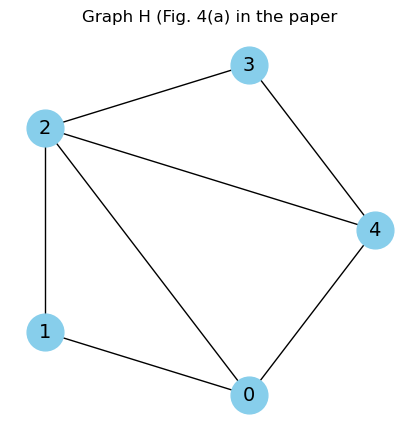

vi = 0: 


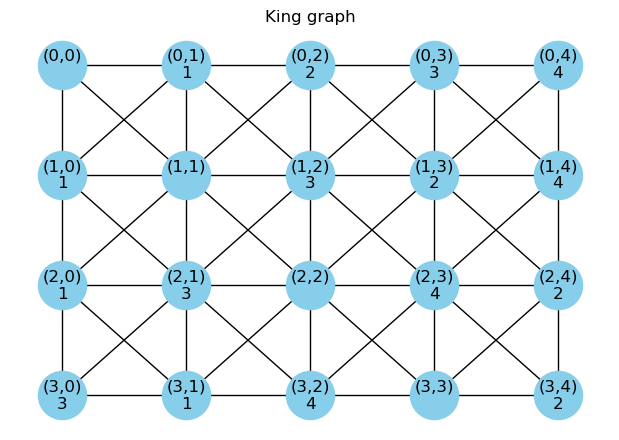

vj = 1: {2} ,  [(0, 1), (1, 0), (2, 0), (3, 1)]
node: (0, 1), distance: 1
v_star: [(0, 1)]
xi =  {(0, 1)}


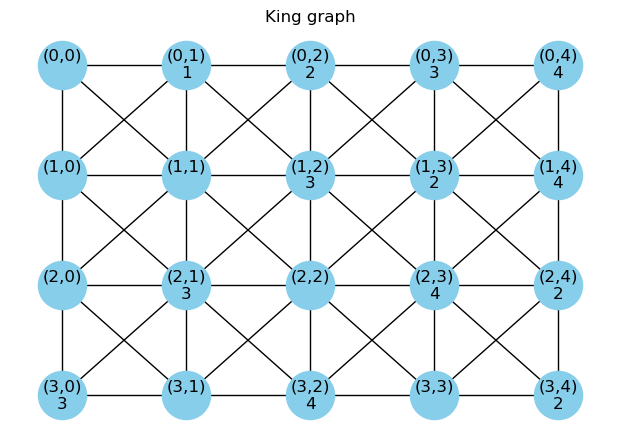

vj = 2: {1, 3, 4} ,  [(0, 2), (1, 3), (2, 4), (3, 4)]
node: (0, 2), distance: 2
node: (1, 3), distance: 2
v_star: [(0, 2), (1, 3)]
xi =  {(0, 2), (1, 3)}


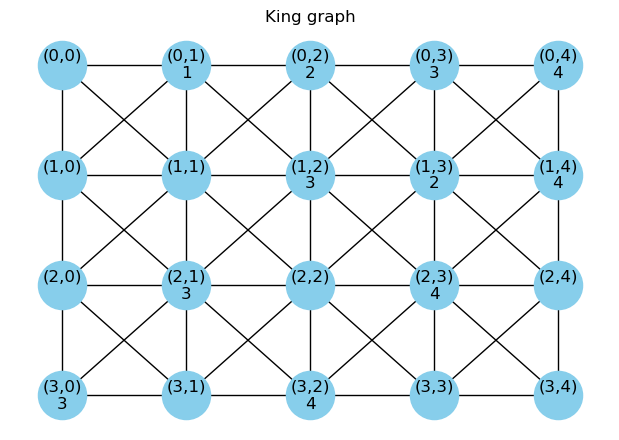

vj = 4: {2, 3} ,  [(0, 4), (1, 4), (2, 3), (3, 2)]
node: (2, 3), distance: 1
node: (0, 4), distance: 1
node: (1, 4), distance: 1
v_star: [(2, 3), (0, 4), (1, 4)]
xi =  {(2, 3), (3, 2), (0, 4), (1, 4)}


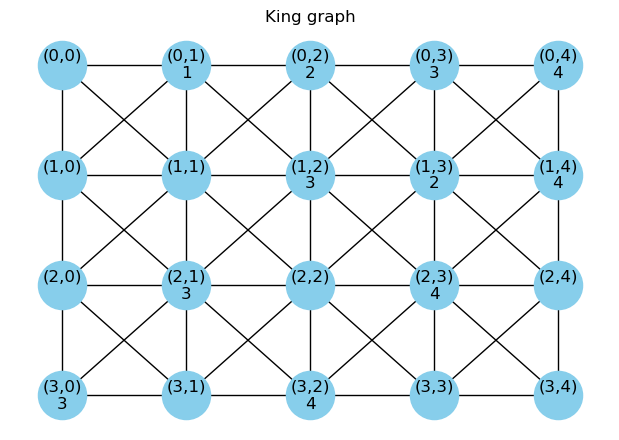

In [27]:
import networkx as nx
from collections import deque, defaultdict
import matplotlib.pyplot as plt

###############################################################
# 無向グラフの描画
def Show_Graph(H):
    # PyGraphvizのcircoレイアウトを使用してノードの位置を計算
    pos = nx.drawing.nx_agraph.graphviz_layout(H, prog='circo')

    plt.figure(figsize=(4, 4))
    nx.draw(H, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=14, font_color='black')
    plt.title('Graph H (Fig. 4(a) in the paper')
    plt.show()

###############################################################
# キンググラフ G に val 属性を追加し、グラフ H のノードの値を格納
def InitializeG(n, H_nodes):
    G = nx.grid_2d_graph(n-1, n)

    # 斜め方向のエッジを追加
    for x, y in G.nodes():
        if (x+1, y+1) in G.nodes():
            G.add_edge((x, y), (x+1, y+1))
        if (x+1, y-1) in G.nodes():
            G.add_edge((x, y), (x+1, y-1))
    
    for x, y in G.nodes():
        if x == 0:  # 第0行の場合
            G.nodes[(x, y)]['val'] = H_nodes[y]
        else:
            # x + y が偶数の場合
            if (x + y) % 2 == 0:
                G.nodes[(x, y)]['val'] = G.nodes[(x - 1, max(0, y - 1))]['val']
            # x + y が奇数の場合
            else:
                G.nodes[(x, y)]['val'] = G.nodes[(x - 1, min(n - 1, y + 1))]['val']
    return G

###############################################################
# 格子状レイアウトでキンググラフを描画
def Show_KingGraph(G):
    # yを横、-xを縦にすることで正しい表現（行, 列）になる
    pos = {(x, y): (y, -x) for x, y in G.nodes()}

    # ノードラベルを設定
    # labels = {(x, y): f"({x},{y})" for x, y in G.nodes()}
    labels = {(x, y): f"({x},{y})\n{G.nodes[(x, y)]['val']}" for x, y in G.nodes()}

    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1200, node_color='skyblue', font_size=12, font_color='black')
    plt.title('King graph')
    plt.show()

def set_node_val(G, node, val):
    G.nodes[node]['val'] = val

def get_nodes_with_val(G, val):
    return [node for node, data in G.nodes(data=True) if data.get('val') == val]

###############################################################
def bfs_shortest_path(G, source_nodes, target_nodes):
    visited = set()
    queue = deque([(node, 0) for node in source_nodes])
    
    while queue:
        current_node, distance = queue.popleft()
        if current_node in target_nodes:
            return current_node, distance
        
        if current_node not in visited:
            visited.add(current_node)
            for neighbor in G.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, distance + 1))
    return None, float('inf')

###############################################################
def mVG(G, nodesG, nodesH):
    nodesH_G = [node for node in G.nodes() if G.nodes[node]['val'] in nodesH]

    subG1_vals = {G.nodes[node]['val'] for node in nodesG}
    subG1 = G.subgraph([node for node in G if G.nodes[node]['val'] in subG1_vals])

    # ここはOK
    distance_table = defaultdict(dict)
    for node in nodesH_G:
        val = G.nodes[node]['val']
        phi_val = get_nodes_with_val(G, val)
        for target_node in nodesG:
            nearest_node, distance = bfs_shortest_path(G, phi_val, [target_node])
            distance_table[node][target_node] = distance
            
    # Debugging: Print the distance table
    # print("Distance Table:")
    # for key, value in distance_table.items():
    #     print(f"{key}: {value}")

    # ここも多分OK
    v_star = []
    for distance in range(1, len(G)):
        for node in subG1.nodes:
            if all(distance_table[target][node] <= distance for target in nodesH_G):
                v_star.append(node)
                print(f"node: {node}, distance: {distance}")
        if v_star:
            break
        
    # Debugging: Print v_star
    print("v_star:", v_star)

    xi = set(v_star)
    for node in nodesH_G:
        if node not in nodesG:  # nodesG に含まれない nodesH_G の頂点を対象とする
            for target_node in v_star:
                if nx.has_path(G, node, target_node):
                    path = nx.shortest_path(G, source=node, target=target_node)
                    xi.update(path)

    xi &= set(nodesG)  # xi に nodesG の頂点のみを残す

    return xi


###############################################################
# main文に相当する部分

###############################################################
# 論文の図4(a)のグラフ

H = nx.Graph()  # 無向グラフ (Undirected Graph)
H.add_nodes_from([0, 1, 2, 3, 4])
H.add_edges_from([(0,1), (0,2), (0,4), (1,2), (2,3), (2,4), (3,4)])

n = H.number_of_nodes()   # グラフHのノード数
H_nodes = list(H.nodes()) # グラフHのノードリスト
Show_Graph(H)

###############################################################
# (n-1)xn のキンググラフG

G = InitializeG(n, H_nodes)

# Show_KingGraph(G)

###############################################################
vi = 0  # テストテストテスト
print(f"vi = {vi}: ")

# 6 行目
for node in get_nodes_with_val(G, H_nodes[vi]):
    set_node_val(G, node, '')

Show_KingGraph(G)

# 7 - 9 行目
for vj in H.neighbors(vi):
    print(f"vj = {vj}: ", end='')
    nodesH = set(H.neighbors(vj)) - {vi}
    nodesG = get_nodes_with_val(G, H_nodes[vj])
    print(nodesH, ", ", nodesG)
    xi = mVG(G, nodesG, nodesH)
    print("xi = ", xi)
    
    for node in get_nodes_with_val(G, H_nodes[vj]):
        set_node_val(G, node, '')
    for node in xi:
        set_node_val(G, node, H_nodes[vj])
    
    Show_KingGraph(G)
